# Audio ML Tutorial

Learning how to make a classifier for audion files from [this tutorial](https://www.youtube.com/watch?v=ZLIPkmmDJAc), and adapting it to the data for the challenge

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 19/05/2025   | Martin | Create  | Notebook created to run through audio ML tutorial. Load and decoded audio to tensor | 

# Content

* [Data Exploration](#data-exploration)

# Data Exploration

Check what are the requirements for submission and metadata that is provided

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

import librosa
import librosa.display

## Submission details

1. Columns in the sample submission match values in `primary_label` in taxonomy
2. Each row in submission is the soundscape_id + end time in seconds as format `soundscape_[soundscape_id]_[end_time]`
3. Each row is a contiguous 5s snippet of the test soundscape

In [3]:
# Sample submission file
sample_submission = pl.read_csv('data/sample_submission.csv')
sample_submission.head()

row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,1564122,21038,21116,21211,22333,22973,22976,24272,24292,24322,41663,41778,41970,42007,42087,42113,46010,47067,476537,476538,48124,50186,517119,523060,528041,52884,548639,…,spepar1,srwswa1,stbwoo2,strcuc1,strfly1,strher,strowl1,tbsfin1,thbeup1,thlsch3,trokin,tropar,trsowl,turvul,verfly,watjac1,wbwwre1,whbant1,whbman1,whfant1,whmtyr1,whtdov,whttro1,whwswa1,woosto,y00678,yebela1,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""soundscape_8358733_5""",0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,…,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
"""soundscape_8358733_10""",0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,…,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
"""soundscape_8358733_15""",0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,…,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854


In [4]:
# Taxonomy file
taxonomy = pl.read_csv('data/taxonomy.csv')
taxonomy.head()

primary_label,inat_taxon_id,scientific_name,common_name,class_name
str,i64,str,str,str
"""1139490""",1139490,"""Ragoniella pulchella""","""Ragoniella pulchella""","""Insecta"""
"""1192948""",1192948,"""Oxyprora surinamensis""","""Oxyprora surinamensis""","""Insecta"""
"""1194042""",1194042,"""Copiphora colombiae""","""Copiphora colombiae""","""Insecta"""
"""126247""",126247,"""Leptodactylus insularum""","""Spotted Foam-nest Frog""","""Amphibia"""
"""1346504""",1346504,"""Neoconocephalus brachypterus""","""Neoconocephalus brachypterus""","""Insecta"""


In [5]:
set(sample_submission.columns).difference(set(taxonomy['primary_label']))

{'row_id'}

## Training data

Match information from training label to audio file

In [6]:
train_details = pl.read_csv('data/train.csv', infer_schema_length=None)
train_details.head()

primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
str,str,str,str,str,f64,str,str,str,str,str,str,str
"""1139490""","""['']""","""['']""","""1139490/CSA36385.ogg""","""CSA""",0.0,"""http://colecciones.humboldt.or…","""7.3206""","""-73.7128""","""Ragoniella pulchella""","""Ragoniella pulchella""","""Fabio A. Sarria-S""","""cc-by-nc-sa 4.0"""
"""1139490""","""['']""","""['']""","""1139490/CSA36389.ogg""","""CSA""",0.0,"""http://colecciones.humboldt.or…","""7.3206""","""-73.7128""","""Ragoniella pulchella""","""Ragoniella pulchella""","""Fabio A. Sarria-S""","""cc-by-nc-sa 4.0"""
"""1192948""","""['']""","""['']""","""1192948/CSA36358.ogg""","""CSA""",0.0,"""http://colecciones.humboldt.or…","""7.3791""","""-73.7313""","""Oxyprora surinamensis""","""Oxyprora surinamensis""","""Fabio A. Sarria-S""","""cc-by-nc-sa 4.0"""
"""1192948""","""['']""","""['']""","""1192948/CSA36366.ogg""","""CSA""",0.0,"""http://colecciones.humboldt.or…","""7.28""","""-73.8582""","""Oxyprora surinamensis""","""Oxyprora surinamensis""","""Fabio A. Sarria-S""","""cc-by-nc-sa 4.0"""
"""1192948""","""['']""","""['']""","""1192948/CSA36373.ogg""","""CSA""",0.0,"""http://colecciones.humboldt.or…","""7.3791""","""-73.7313""","""Oxyprora surinamensis""","""Oxyprora surinamensis""","""Fabio A. Sarria-S""","""cc-by-nc-sa 4.0"""


In [7]:
train_details.filter(
  ~pl.col('secondary_labels').str.starts_with("['']"),
  ~pl.col('secondary_labels').str.starts_with("[]"),
).head()

primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
str,str,str,str,str,f64,str,str,str,str,str,str,str
"""126247""","""['65448', '22976', '476538']""","""['advertisement call']""","""126247/XC941297.ogg""","""XC""",3.5,"""https://xeno-canto.org/941297""","""9.0465""","""-79.3024""","""Leptodactylus insularum""","""Spotted Foam-nest Frog""","""Chris Harrison""","""cc-by-nc-sa 4.0"""
"""22973""","""['compau']""","""['advertisement call', 'chorus…","""22973/XC892932.ogg""","""XC""",4.5,"""https://xeno-canto.org/892932""","""10.6144""","""-61.2238""","""Leptodactylus fuscus""","""Whistling Grass Frog""","""Chris Harrison""","""cc-by-nc-sa 4.0"""
"""476538""","""['65448']""","""['advertisement call']""","""476538/XC926710.ogg""","""XC""",4.5,"""https://xeno-canto.org/926710""","""9.0709""","""-79.2983""","""Elachistocleis panamensis""","""Panama Humming Frog""","""Chris Harrison""","""cc-by-nc-sa 4.0"""
"""65349""","""['65547']""","""['advertisement call']""","""65349/XC941283.ogg""","""XC""",4.5,"""https://xeno-canto.org/941283""","""8.6211""","""-80.1393""","""Dendropsophus ebraccatus""","""Harlequin Treefrog""","""Chris Harrison""","""cc-by-nc-sa 4.0"""
"""65448""","""['22976']""","""['advertisement call']""","""65448/XC941294.ogg""","""XC""",4.5,"""https://xeno-canto.org/941294""","""9.0416""","""-79.3026""","""Engystomops pustulosus""","""Túngara Frog""","""Chris Harrison""","""cc-by-nc-sa 4.0"""


Explore the audio file `126247/XC941297.ogg` as it contains a primary label of "126247" (Spotted Foam-nest Frog) and other frogs ['65448', '22976', '476538']

In [8]:
taxonomy.filter(
  pl.col('primary_label').is_in(['126247', '65448', '22976', '476538'])
)

primary_label,inat_taxon_id,scientific_name,common_name,class_name
str,i64,str,str,str
"""126247""",126247,"""Leptodactylus insularum""","""Spotted Foam-nest Frog""","""Amphibia"""
"""22976""",22976,"""Leptodactylus fragilis""","""Mexican White-lipped Frog""","""Amphibia"""
"""476538""",476538,"""Elachistocleis panamensis""","""Panama Humming Frog""","""Amphibia"""
"""65448""",65448,"""Engystomops pustulosus""","""Túngara Frog""","""Amphibia"""


In [9]:
audio_path = "data/train_audio/126247/XC941297.ogg"
ipd.Audio(audio_path)

In [10]:
# Loading the audio
SR = 32_000
audio, audio_sr = librosa.load(audio_path, sr=SR)

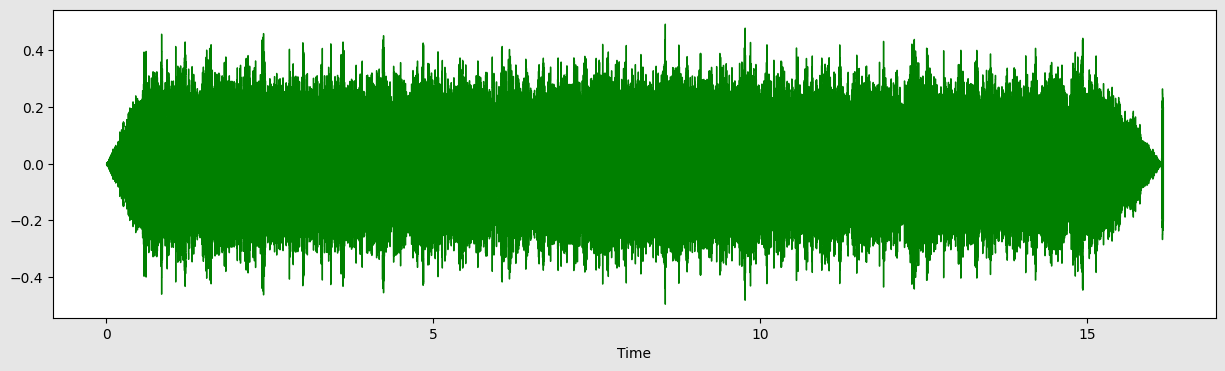

In [11]:
# Showing the waveform
plt.figure(figsize=(15, 4), facecolor=(.9, .9, .9))
librosa.display.waveshow(audio, sr=SR, color='green')

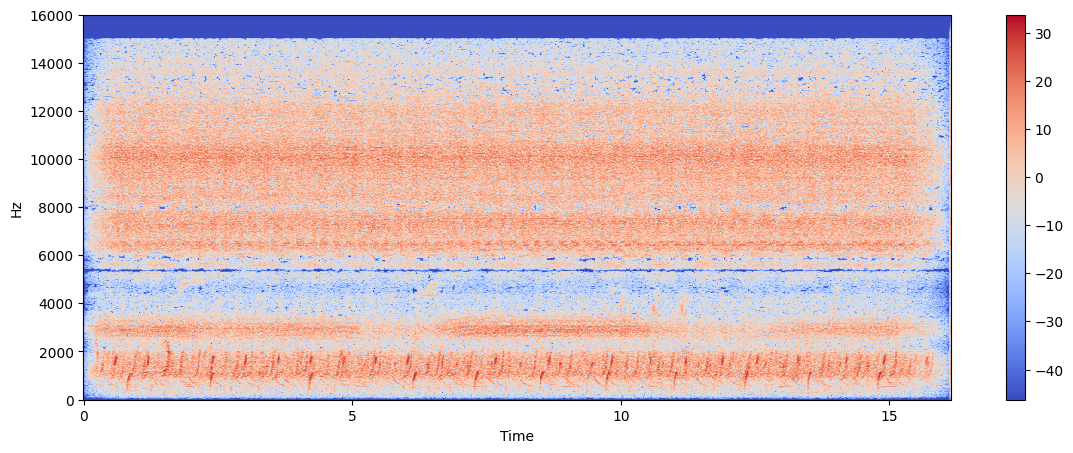

In [12]:
# Showing spectrogram
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=SR, x_axis='time', y_axis='hz')
plt.colorbar()

---

# Tutorial Classification Model

Original tutorial used a set of audio clips (~3s) to classify the presence of a species of birds. The prediction challenge was the count the number of times the species can be heard from a longer 3min clip.

Here I am adapting the code just to predict the presence of a single species of animals for each clip

In [13]:
import os
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
def load_32k_mono(filename: str):
  # Load the encoded ogg file
  encoded = tf.io.read_file(filename)
  # Decode the audio
  # NOTE: Files have already been resampled to 32k and OGG format
  ogg = tfio.audio.decode_vorbis(encoded)

  return ogg

In [15]:
ENTRY_NO = 1
path = f"data/train_audio/{train_details['filename'][ENTRY_NO]}"
path

'data/train_audio/1139490/CSA36389.ogg'

In [39]:
load_32k_mono(path)

<tf.Tensor: shape=(3089207, 1), dtype=float32, numpy=
array([[-7.3378892e-06],
       [ 1.0008220e-05],
       [-8.9482928e-06],
       ...,
       [-3.7602856e-04],
       [-4.6555183e-04],
       [-4.9038843e-04]], dtype=float32)>